# Baseline

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_union
import lightgbm as lgb

from lightgbm import LGBMClassifier

In [3]:
from thesis_lib.utils import * 

In [4]:
from thesis_lib.modelling.data import *

#### First we load the data, which is already splitted on train, validation and test sets. 

In [5]:
data = Data().load('data/hospital_dataset')
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


In [9]:
variables = data.get_variables_dict()

#### Feature selection & feature engineering

##### We need to choose the features we're going to train out model with. As a rule of thumb, in this first experiment, we'll use all the numerical features plus only the categorical features with less than 10 categories (as they're easier to encode)

In [10]:
class FeaturePreProcessor():
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
        
        
    def transform(self,X):
        X['admission_weekday'] = pd.to_datetime(X['admission_date']).dt.weekday.astype('str')
        X['date_weekday'] = pd.to_datetime(X['date']).dt.weekday.astype('str')
        return X
                
    

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, keys,is_categorical=False):
        self.key = keys
        self.is_categorical = is_categorical

    def fit(self, X, y=None):
        return self

    def transform(self, X):     
        return X[self.key].astype(str) if self.is_categorical else X[self.key]
    
class CustomScaler(StandardScaler):
    
    def __init__ (self, with_mean=True,with_std=True):
        super().__init__(with_mean=with_mean, 
                         with_std=with_std)
    
    def fit(self,X,y=None):
        self.feature_names = list(X.columns)
        return super().fit(X)
    
    def transform(self,X):
        return super().transform(X)
        
    def get_feature_names(self):
        return self.feature_names

class CustomEncoder(OneHotEncoder):
    
    def __init__(self):
        super().__init__(handle_unknown='ignore')
        
    def fit(self,X,y=None):
        self.features_headers = list(X.columns)
        return super().fit(X)
        
    def get_feature_names(self):
        return super().get_feature_names(self.features_headers)

In [12]:
class FeatureProcessor(Pipeline):
    def __init__(self, features_list, transformer_type):
        self.features_list = features_list
        self.transformer_dict = {'categorical': CustomEncoder(),
                                 'numerical': CustomScaler()}
        
        self.selector  = ItemSelector(
            keys=features_list,is_categorical= (transformer_type == 'categorical'))
        
        self.transformer = self.transformer_dict[transformer_type]
        
        super().__init__([('selector',self.selector),
                          (transformer_type, self.transformer)])
        
    def get_feature_names(self):
        return self.transformer.get_feature_names()

In [13]:
def build_pipeline(categorical_features,
                   numerical_features):
        
        features_union = make_union(FeatureProcessor(numerical_features ,'numerical'),
                                    FeatureProcessor(categorical_features,'categorical'))
        
        pipeline = Pipeline(steps=[('preprocessing', FeaturePreProcessor() ),
                                   ('feature_engineering', features_union)])
        print(pipeline)
        
        return pipeline

In [26]:
class BaselineModel():
    def __init__(self, categorical_features,
                        numerical_features):
        
        self.categorical = categorical_features
        self.numerical = numerical_features
        
        self.pipeline = build_pipeline(self.categorical,
                                      self.numerical)
        
    
    @property
    def model_features(self):
        
        feature_names = []
        transformers = self.pipeline.named_steps['feature_engineering'].transformer_list
        for transformer in transformers:
            transformer_features = transformer[1].get_feature_names()
            feature_names.extend(transformer_features)
          
        #HACK
        print(feature_names)
        feature_names = ["".join (c if c.isascii() and c.isalnum() else "_" for c in str(x)) 
                         for x in feature_names]
        
        return feature_names
    
    def transform(self,data):
        
        print('Fitting pipeline...')
        self.pipeline.fit(data.train.X)
        
        print('Transforming data...')
        self.X_train = self.pipeline.transform(data.train.X)
        self.y_train = data.train.y
        
        self.X_val = self.pipeline.transform(data.val.X)
        self.y_val = data.val.y
        
        #self.X_test = self.pipeline.transform(data.test.X)
        #self.y_test = data.test.y
        
    
    def train_classifier(self, params=None):
        
        lgb_train = lgb.Dataset(self.X_train,
                                label=self.y_train,
                                feature_name=self.model_features
                               )
        lgb_eval = lgb.Dataset(self.X_val,
                               label=self.y_val,
                               feature_name=self.model_features,
                               reference=lgb_train)
        
        print('Training classifier')
        
        
        default_model_params = {'objective': 'binary', 
                                'metric': 'auc',
                                'is_unbalance': True}
        if not params:
            params = default_model_params
        else:
            for key in default_model_params:
                params[key] = default_model_params[key]
            
                                
        self.classifier = lgb.train(params, lgb_train,valid_sets=[lgb_eval])
        
        
    def predict(self,X_transf):
        return  self.classifier.predict(X_transf)
    
    def plot_feature_importance(self, importance_type='split',n_features=30):
        
        lgb.plot_importance(self.classifier,figsize=(10,10),
                            max_num_features= n_features,
                           importance_type=importance_type)
        
    def get_performance_metrics(self):
        
        auc_train = roc_auc_score(self.y_train, self.predict(self.X_train))
        auc_val = roc_auc_score(self.y_val, self.predict(self.X_val))
        
        print('training AUC ROC score: ', auc_train)

        print('validation AUC ROC score: ', auc_val)
        
        print('relative overfitting: ', abs(auc_train-auc_val)/auc_train)
        

In [27]:
variables['categorical_variables']

['date',
 'images_requester_roles',
 'images_study_types',
 'labos_requester_roles',
 'sectors_last_sector',
 'sectors_names',
 'surgeries_actual',
 'surgeries_anesthesia_types',
 'surgeries_bact_positive',
 'surgeries_injury_condition',
 'surgeries_post_surgery_condition',
 'surgeries_scheduled',
 'surgeries_scheduled_done',
 'surgeries_services',
 'surgeries_types',
 'gender',
 'insurance_entity',
 'entity_group',
 'origin',
 'admission_sector',
 'isolation',
 'presumptive_dianogsis',
 'responsible_sector',
 'ARM_TEP',
 'CEC_TEP',
 'request_origin',
 'request',
 'request_diagnosis',
 'request_sector',
 'admission_date']

In [28]:
variables['numerical_variables']

['hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'sectors_count',
 'sectors_last_stay',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count',
 'emergency_service',
 'new_born_weight',
 'new_born_gestation_age',
 'PIM2TEP',
 'high_risk_TEP',
 'low_risk_TEP',
 'patient_age']

In [29]:
baseline = BaselineModel(categorical_features = ['date_weekday','request_origin','origin','entity_group',
                                                'gender','request_sector','insurance_entity',
                                                'admission_sector','emergency_service'],
                         numerical_features = ['patient_age','hosp_day_number','images_count','images_cumulative',
                                              'labos_count','labos_cumulative','surgeries_count','surgeries_cumulative',
                                              'new_born_weight','new_born_gestation_age'])

Pipeline(memory=None,
         steps=[('preprocessing',
                 <__main__.FeaturePreProcessor object at 0x1a28c318d0>),
                ('feature_engineering',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('featureprocessor-1',
                                                 FeatureProcessor(features_list=['patient_age',
                                                                                 'hosp_day_number',
                                                                                 'images_count',
                                                                                 'images_cumulative',
                                                                                 'labos_count',
                                                                                 'labos_cumulative',
                                                                                 'surgeries_count',
                         

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [30]:
baseline.transform(data)

Fitting pipeline...


/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Transforming data...


In [31]:
%%capture
baseline.train_classifier({'max_depth': 9,
                          'random_state': 2020,
                          'n_estimators': 100,
                          'learning_rate': 0.1})

In [32]:
baseline.get_performance_metrics()

training AUC ROC score:  0.8369930398416293
validation AUC ROC score:  0.8261846116517915
relative overfitting:  0.012913402711070278


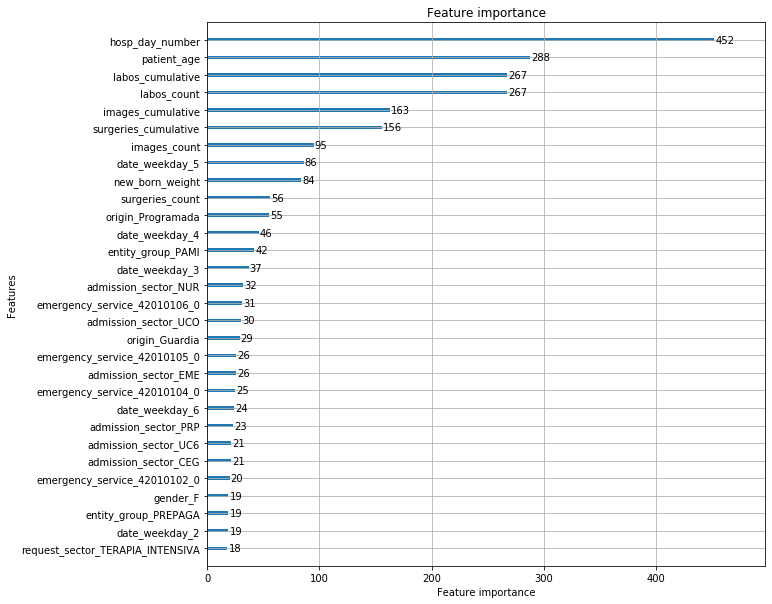

In [33]:
baseline.plot_feature_importance()

In [34]:
full_model = BaselineModel(categorical_features = variables['categorical_variables'],
                         numerical_features = variables['numerical_variables'])

Pipeline(memory=None,
         steps=[('preprocessing',
                 <__main__.FeaturePreProcessor object at 0x1a2881eb10>),
                ('feature_engineering',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('featureprocessor-1',
                                                 FeatureProcessor(features_list=['hosp_day_number',
                                                                                 'images_count',
                                                                                 'images_cumulative',
                                                                                 'images_emergencies',
                                                                                 'images_requester_roles_count',
                                                                                 'images_requesters_count',
                                                                                 'i...
       

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [35]:
full_model.transform(data)

Fitting pipeline...


/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Transforming data...


In [36]:
%%capture
full_model.train_classifier({'max_depth': 9,
                          'random_state': 2020,
                          'n_estimators': 100,
                          'learning_rate': 0.1})

In [37]:
full_model.get_performance_metrics()

training AUC ROC score:  0.8781818811815592
validation AUC ROC score:  0.85999539626169
relative overfitting:  0.020709246352703138


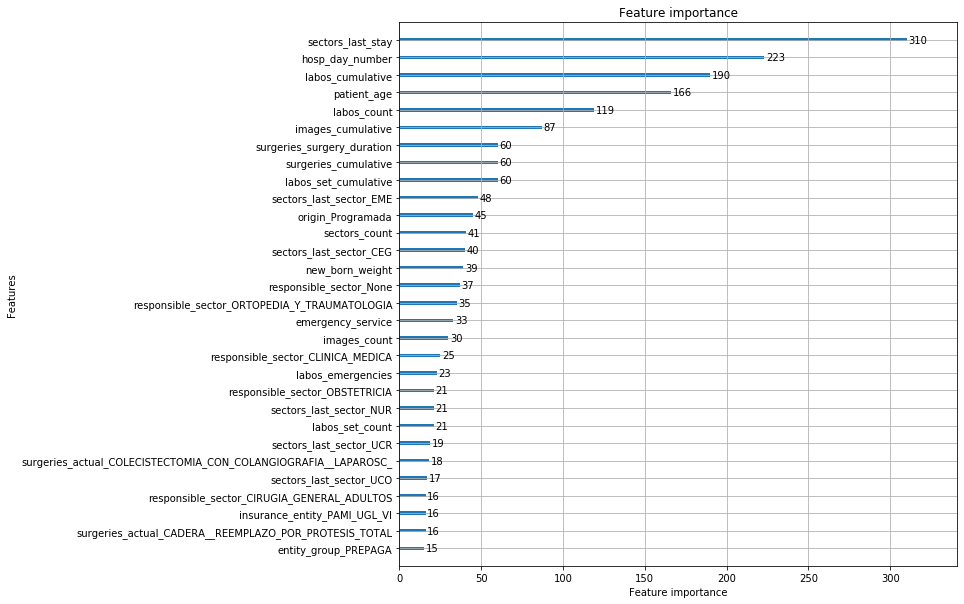

In [38]:
full_model.plot_feature_importance()